In [1]:
import tensorflow as tf
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
def loadData():
    data = io.loadmat("face_landmark.mat")
    images = data["images"]
    landmarks = data["landmarks"]
    print("im_shape:", images.shape)
    print("landmarks_shape:", landmarks.shape)

    return images, landmarks

In [3]:
images, landmarks = loadData()

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


# Visualize Data

In [4]:
def visualize_data(images, landmarks, num_images):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        for (x, y) in landmarks[i].reshape(-1, 2):
            # Plot keypoints/landmarks on the image
            ax.scatter(x, y, marker='o', s=10, color='r')

    plt.show()

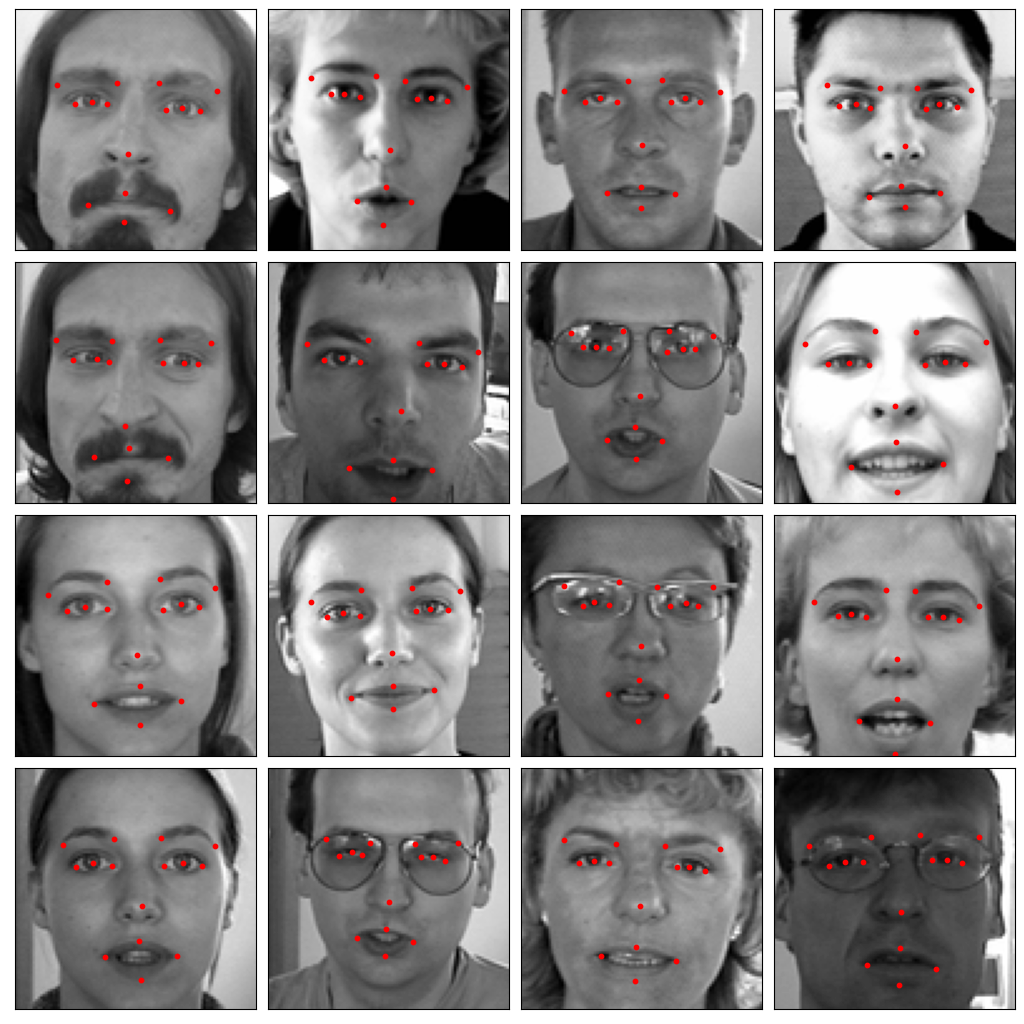

In [5]:
visualize_data(images, landmarks, num_images=16)

# Preprocessing

### split

In [6]:
def split_data(data, size):
    np.random.seed(2023)
    
    idx = np.random.permutation(size)

    train_size = int(size * 0.6)
    val_size = int(size * 0.2)
    test_size = int(size * 0.2)

    train_ds = data[idx[: train_size]]
    val_ds = data[idx[train_size: train_size + val_size]]
    test_ds = data[idx[size - test_size:]]

    return train_ds, val_ds, test_ds

In [7]:
train_img, val_img, test_img = split_data(images, images.shape[0])

In [8]:
train_lmrk, val_lmrk, test_lmrk = split_data(landmarks, landmarks.shape[0])

### Reshape

In [9]:
print(train_img.shape)
print(train_lmrk.shape)

(1284, 96, 96)
(1284, 15, 2)


In [10]:
print(val_img.shape)
print(val_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [11]:
print(test_img.shape)
print(test_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [12]:
train_lmrk = train_lmrk.reshape((1284, -1))
val_lmrk = val_lmrk.reshape((428, -1))
test_lmrk = test_lmrk.reshape((428, -1))

In [13]:
print(train_lmrk.shape)
print(val_lmrk.shape)
print(test_lmrk.shape)

(1284, 30)
(428, 30)
(428, 30)


# Model
* Output은 15개의 얼굴 랜드마크에 해당하는 x, y 좌표이므로 총 30개의 출력 유닛이 필요

In [14]:
from tensorflow.keras import regularizers

# Define the input shape
input_layer = tf.keras.Input(shape=(96, 96, 1))

# Define the convolution and pooling layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the tensor output for the Fully Connected layer
x = tf.keras.layers.Flatten()(x)

# Define the fully connected layer
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.Dropout(0.25)(x)

# Define the output layer (30 units for 15 landmarks x and y coordinates)
output_layer = tf.keras.layers.Dense(30)(x)

# Create the model
model = tf.keras.Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

## Predict

In [15]:
@tf.function
def predict(x):
    return model(x, training=False)

# Optimization

In [16]:
@tf.function
def optimize(x,y_true,loss_function):
    with tf.GradientTape() as tape:
        y_pred = predict(x)
        loss = loss_function(y_pred, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss
* 실제 레이블(y_true)와 모델의 예측 결과(y)를 입력

In [18]:
@tf.function
def l1_loss(y_pred, y_true):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

@tf.function
def l2_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def cosine_loss(y_pred, y_true):
    # Normalize each vector
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    # Compute the dot product (cosine similarity)
    dot_product = tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1)
    # Subtract the dot product from 1 to get the loss
    return 1 - tf.reduce_mean(dot_product)


In [19]:
def combine_l2_cosine_loss(y_pred, y_true, lamda=0.6):
    return l2_loss(y_pred, y_true) + lamda*cosine_loss(y_pred, y_true)

# Train & Evaluation

In [20]:
""" start training """
loss_function = combine_l2_cosine_loss

max_epochs = 1000
batch_size = 32


loss_history = []
val_loss_best = np.inf
train_size = int(images.shape[0] * 0.6)

#Early stopping hyperparameter
patience = 50  # number of epochs to wait before stopping if there is no improvement
wait = 0  # counter for epochs without improvement


for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(train_size)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(train_img[batch_idx], train_lmrk[batch_idx], loss_function)
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(val_img)
    val_loss = loss_function(y, val_lmrk).numpy()

    # Early stopping check
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    print('Epoch:', epoch, '. Training Loss:', train_loss, ' Validation Loss:', val_loss, ' Best Validation Loss:', val_loss_best)
    loss_history.append([train_loss, val_loss])

Epoch: 0 . Training Loss: 3176.6182  Validation Loss: 2201.092  Best Validation Loss: 2201.092
Epoch: 1 . Training Loss: 2191.0317  Validation Loss: 1581.0859  Best Validation Loss: 1581.0859
Epoch: 2 . Training Loss: 1585.7627  Validation Loss: 1199.6128  Best Validation Loss: 1199.6128
Epoch: 3 . Training Loss: 1173.0385  Validation Loss: 1111.8667  Best Validation Loss: 1111.8667
Epoch: 4 . Training Loss: 1091.8318  Validation Loss: 935.3759  Best Validation Loss: 935.3759
Epoch: 5 . Training Loss: 1037.1528  Validation Loss: 746.1822  Best Validation Loss: 746.1822
Epoch: 6 . Training Loss: 739.3625  Validation Loss: 675.0983  Best Validation Loss: 675.0983
Epoch: 7 . Training Loss: 642.1056  Validation Loss: 611.0402  Best Validation Loss: 611.0402
Epoch: 8 . Training Loss: 628.6992  Validation Loss: 534.2221  Best Validation Loss: 534.2221
Epoch: 9 . Training Loss: 517.40045  Validation Loss: 483.72318  Best Validation Loss: 483.72318
Epoch: 10 . Training Loss: 457.98865  Validat

Epoch: 87 . Training Loss: 115.736626  Validation Loss: 116.65965  Best Validation Loss: 107.404945
Epoch: 88 . Training Loss: 157.48044  Validation Loss: 110.86929  Best Validation Loss: 107.404945
Epoch: 89 . Training Loss: 93.06297  Validation Loss: 123.37852  Best Validation Loss: 107.404945
Epoch: 90 . Training Loss: 80.77911  Validation Loss: 115.67555  Best Validation Loss: 107.404945
Epoch: 91 . Training Loss: 141.1105  Validation Loss: 109.46902  Best Validation Loss: 107.404945
Epoch: 92 . Training Loss: 117.779236  Validation Loss: 131.23778  Best Validation Loss: 107.404945
Epoch: 93 . Training Loss: 157.13802  Validation Loss: 112.09034  Best Validation Loss: 107.404945
Epoch: 94 . Training Loss: 78.47799  Validation Loss: 105.145424  Best Validation Loss: 105.145424
Epoch: 95 . Training Loss: 78.210045  Validation Loss: 122.39325  Best Validation Loss: 105.145424
Epoch: 96 . Training Loss: 108.36809  Validation Loss: 125.88083  Best Validation Loss: 105.145424
Epoch: 97 .

Epoch: 175 . Training Loss: 56.80863  Validation Loss: 94.569855  Best Validation Loss: 93.54613
Epoch: 176 . Training Loss: 96.44587  Validation Loss: 94.72052  Best Validation Loss: 93.54613
Epoch: 177 . Training Loss: 94.376854  Validation Loss: 101.73463  Best Validation Loss: 93.54613
Epoch: 178 . Training Loss: 104.16511  Validation Loss: 95.10317  Best Validation Loss: 93.54613
Epoch: 179 . Training Loss: 64.00952  Validation Loss: 100.855286  Best Validation Loss: 93.54613
Epoch: 180 . Training Loss: 78.33314  Validation Loss: 98.2727  Best Validation Loss: 93.54613
Epoch: 181 . Training Loss: 90.206314  Validation Loss: 92.70364  Best Validation Loss: 92.70364
Epoch: 182 . Training Loss: 82.4681  Validation Loss: 119.37379  Best Validation Loss: 92.70364
Epoch: 183 . Training Loss: 113.369354  Validation Loss: 116.98712  Best Validation Loss: 92.70364
Epoch: 184 . Training Loss: 94.663  Validation Loss: 91.54612  Best Validation Loss: 91.54612
Epoch: 185 . Training Loss: 84.61

Epoch: 261 . Training Loss: 60.090885  Validation Loss: 92.41812  Best Validation Loss: 80.753876
Epoch: 262 . Training Loss: 82.75671  Validation Loss: 97.205925  Best Validation Loss: 80.753876
Epoch: 263 . Training Loss: 67.522194  Validation Loss: 82.65515  Best Validation Loss: 80.753876
Epoch: 264 . Training Loss: 101.70522  Validation Loss: 88.451706  Best Validation Loss: 80.753876
Epoch: 265 . Training Loss: 55.614845  Validation Loss: 104.185486  Best Validation Loss: 80.753876
Epoch: 266 . Training Loss: 109.948944  Validation Loss: 93.389366  Best Validation Loss: 80.753876
Epoch: 267 . Training Loss: 82.06572  Validation Loss: 80.9527  Best Validation Loss: 80.753876
Epoch: 268 . Training Loss: 59.131775  Validation Loss: 84.2674  Best Validation Loss: 80.753876
Epoch: 269 . Training Loss: 107.64041  Validation Loss: 86.12228  Best Validation Loss: 80.753876
Epoch: 270 . Training Loss: 62.078773  Validation Loss: 84.92868  Best Validation Loss: 80.753876
Epoch: 271 . Train

Epoch: 349 . Training Loss: 59.699615  Validation Loss: 70.270355  Best Validation Loss: 69.25177
Epoch: 350 . Training Loss: 67.031006  Validation Loss: 69.48498  Best Validation Loss: 69.25177
Epoch: 351 . Training Loss: 39.046246  Validation Loss: 69.68674  Best Validation Loss: 69.25177
Epoch: 352 . Training Loss: 40.151455  Validation Loss: 70.49418  Best Validation Loss: 69.25177
Epoch: 353 . Training Loss: 70.18251  Validation Loss: 69.3005  Best Validation Loss: 69.25177
Epoch: 354 . Training Loss: 61.34198  Validation Loss: 70.63836  Best Validation Loss: 69.25177
Epoch: 355 . Training Loss: 55.39918  Validation Loss: 71.35757  Best Validation Loss: 69.25177
Epoch: 356 . Training Loss: 54.436142  Validation Loss: 69.24728  Best Validation Loss: 69.24728
Epoch: 357 . Training Loss: 46.252293  Validation Loss: 69.924736  Best Validation Loss: 69.24728
Epoch: 358 . Training Loss: 58.93737  Validation Loss: 71.71144  Best Validation Loss: 69.24728
Epoch: 359 . Training Loss: 57.30

Epoch: 436 . Training Loss: 37.646378  Validation Loss: 81.86351  Best Validation Loss: 61.665382
Epoch: 437 . Training Loss: 60.318142  Validation Loss: 81.67493  Best Validation Loss: 61.665382
Epoch: 438 . Training Loss: 41.247925  Validation Loss: 64.570045  Best Validation Loss: 61.665382
Epoch: 439 . Training Loss: 69.628586  Validation Loss: 80.514366  Best Validation Loss: 61.665382
Epoch: 440 . Training Loss: 55.305553  Validation Loss: 78.72805  Best Validation Loss: 61.665382
Epoch: 441 . Training Loss: 54.802536  Validation Loss: 62.64818  Best Validation Loss: 61.665382
Epoch: 442 . Training Loss: 31.796062  Validation Loss: 73.52173  Best Validation Loss: 61.665382
Epoch: 443 . Training Loss: 57.9468  Validation Loss: 71.171776  Best Validation Loss: 61.665382
Epoch: 444 . Training Loss: 54.46872  Validation Loss: 61.69473  Best Validation Loss: 61.665382
Epoch: 445 . Training Loss: 31.548437  Validation Loss: 64.78861  Best Validation Loss: 61.665382
Epoch: 446 . Trainin

Epoch: 524 . Training Loss: 43.212105  Validation Loss: 55.475163  Best Validation Loss: 55.475163
Epoch: 525 . Training Loss: 33.08027  Validation Loss: 54.689156  Best Validation Loss: 54.689156
Epoch: 526 . Training Loss: 33.247303  Validation Loss: 55.13845  Best Validation Loss: 54.689156
Epoch: 527 . Training Loss: 20.743925  Validation Loss: 55.847744  Best Validation Loss: 54.689156
Epoch: 528 . Training Loss: 34.08251  Validation Loss: 54.438778  Best Validation Loss: 54.438778
Epoch: 529 . Training Loss: 34.628788  Validation Loss: 60.217766  Best Validation Loss: 54.438778
Epoch: 530 . Training Loss: 33.687702  Validation Loss: 62.91741  Best Validation Loss: 54.438778
Epoch: 531 . Training Loss: 38.994984  Validation Loss: 57.528095  Best Validation Loss: 54.438778
Epoch: 532 . Training Loss: 44.48795  Validation Loss: 58.852127  Best Validation Loss: 54.438778
Epoch: 533 . Training Loss: 38.11695  Validation Loss: 55.808273  Best Validation Loss: 54.438778
Epoch: 534 . Tra

Epoch: 612 . Training Loss: 27.594791  Validation Loss: 51.446102  Best Validation Loss: 49.9242
Epoch: 613 . Training Loss: 20.825132  Validation Loss: 51.233906  Best Validation Loss: 49.9242
Epoch: 614 . Training Loss: 26.687782  Validation Loss: 56.4406  Best Validation Loss: 49.9242
Epoch: 615 . Training Loss: 23.557343  Validation Loss: 62.163937  Best Validation Loss: 49.9242
Epoch: 616 . Training Loss: 37.810642  Validation Loss: 51.605354  Best Validation Loss: 49.9242
Epoch: 617 . Training Loss: 17.884184  Validation Loss: 57.25017  Best Validation Loss: 49.9242
Epoch: 618 . Training Loss: 26.422523  Validation Loss: 52.872025  Best Validation Loss: 49.9242
Epoch: 619 . Training Loss: 32.699207  Validation Loss: 53.12162  Best Validation Loss: 49.9242
Epoch: 620 . Training Loss: 19.901506  Validation Loss: 60.526066  Best Validation Loss: 49.9242
Epoch: 621 . Training Loss: 31.432213  Validation Loss: 51.388264  Best Validation Loss: 49.9242
Epoch: 622 . Training Loss: 26.725

Epoch: 699 . Training Loss: 17.407879  Validation Loss: 50.757427  Best Validation Loss: 46.361687
Epoch: 700 . Training Loss: 33.682484  Validation Loss: 50.91055  Best Validation Loss: 46.361687
Epoch: 701 . Training Loss: 27.354355  Validation Loss: 49.601055  Best Validation Loss: 46.361687
Epoch: 702 . Training Loss: 24.47352  Validation Loss: 49.53534  Best Validation Loss: 46.361687
Epoch: 703 . Training Loss: 27.78387  Validation Loss: 51.271458  Best Validation Loss: 46.361687
Epoch: 704 . Training Loss: 26.425388  Validation Loss: 60.072945  Best Validation Loss: 46.361687
Epoch: 705 . Training Loss: 23.020151  Validation Loss: 50.034645  Best Validation Loss: 46.361687
Epoch: 706 . Training Loss: 25.174227  Validation Loss: 47.18216  Best Validation Loss: 46.361687
Epoch: 707 . Training Loss: 16.402004  Validation Loss: 47.78088  Best Validation Loss: 46.361687
Epoch: 708 . Training Loss: 16.236502  Validation Loss: 48.821312  Best Validation Loss: 46.361687
Epoch: 709 . Tra

Epoch: 786 . Training Loss: 19.268234  Validation Loss: 49.53597  Best Validation Loss: 45.98259
Epoch: 787 . Training Loss: 21.295506  Validation Loss: 49.248096  Best Validation Loss: 45.98259
Epoch: 788 . Training Loss: 20.895502  Validation Loss: 49.98333  Best Validation Loss: 45.98259
Epoch: 789 . Training Loss: 12.35154  Validation Loss: 58.285797  Best Validation Loss: 45.98259
Epoch: 790 . Training Loss: 24.337496  Validation Loss: 49.665207  Best Validation Loss: 45.98259
Epoch: 791 . Training Loss: 23.181799  Validation Loss: 49.206623  Best Validation Loss: 45.98259
Epoch: 792 . Training Loss: 16.338388  Validation Loss: 52.43108  Best Validation Loss: 45.98259
Epoch: 793 . Training Loss: 37.816513  Validation Loss: 47.58117  Best Validation Loss: 45.98259
Epoch: 794 . Training Loss: 24.082872  Validation Loss: 55.400444  Best Validation Loss: 45.98259
Epoch: 795 . Training Loss: 16.69233  Validation Loss: 59.266422  Best Validation Loss: 45.98259
Epoch: 796 . Training Loss

### visualization loss

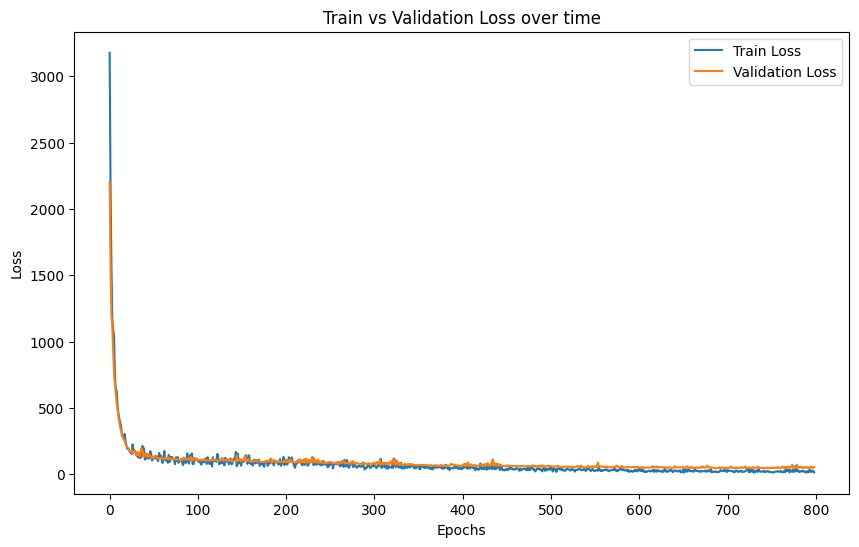

In [21]:
# Convert the history to a pandas dataframe
df_loss_history = pd.DataFrame(loss_history, columns=['train_loss', 'val_loss'])

# plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_loss_history['train_loss'], label='Train Loss')
plt.plot(df_loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over time')
plt.legend()
plt.show()


### Evaluation

In [22]:
test_true = test_lmrk
test_pred = model.predict(test_img)

print("Combine L2 And Cosine Error: ", combine_l2_cosine_loss(test_true, test_pred).numpy())

14/14 [==============================] - 0s 6ms/step
Combine L2 And Cosine Error:  44.977093


### visualize result

14/14 [==============================] - 0s 1ms/step


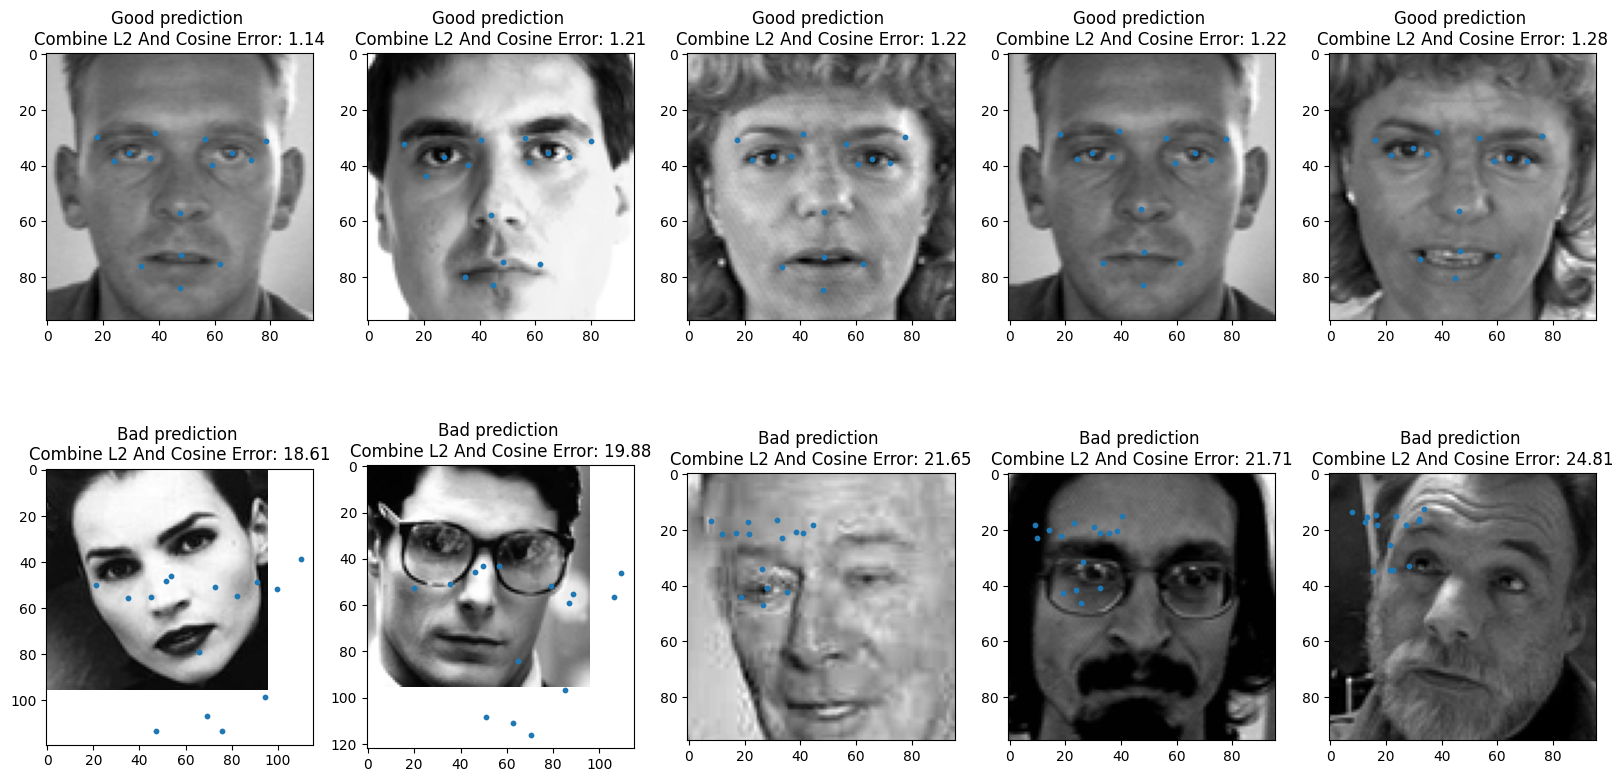

In [23]:
def plot_sample(image, landmarks, ax):
    ax.imshow(image, cmap='gray')
    landmarks = np.reshape(landmarks, (-1, 2)) # reshape to (15, 2)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', s=10)

# suppose we have some predictions and ground truth data
predictions = model.predict(test_img)
ground_truth = test_lmrk  # assume this exists

errors = np.mean(np.abs(predictions - ground_truth), axis=1)
sorted_indices = np.argsort(errors)

# Indices of good predictions
good_indices = sorted_indices[:5]  

# Indices of bad predictions
bad_indices = sorted_indices[-5:]  

fig = plt.figure(figsize=(20,10))
for i in range(5):
    # Good predictions
    ax = fig.add_subplot(2, 5, i+1)
    plot_sample(test_img[good_indices[i]], predictions[good_indices[i]], ax)
    ax.set_title("Good prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[good_indices[i]]))

    # Bad predictions
    ax = fig.add_subplot(2, 5, i+6)
    plot_sample(test_img[bad_indices[i]], predictions[bad_indices[i]], ax)
    ax.set_title("Bad prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[bad_indices[i]]))

plt.show()
